In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import os
%matplotlib inline

In [2]:
# If the names have not been downloaded
if not os.path.exists('names.txt'):
    # download the names.txt file from github
    !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

with open('names.txt','r') as h:
    words = [w.rstrip() for w in h.readlines()]

print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [3]:
chars = sorted(set(''.join(words)))
chars = ['.']+chars

#
# same result as two rows above as '.' is less than any [a-z] or [0-9]
# chars = sorted(set('.'.join(words))):
# print('a' > '.')
# (True)

# same:
#chars = ['.']+[*chars]

N = len(chars)
print(f"\nTotal characters: {N=}\n")

stoi = { s:i for i,s in enumerate(chars)}
itos = { i:s for s,i in stoi.items()}
print(itos)

encode = lambda c : stoi[c]
decode = lambda i : itos[i]

print(encode('a'))
print(decode(1))


Total characters: N=27

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
1
a


In [198]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

random.seed(42)
random.shuffle(words)

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [209]:
class Linear():
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)/fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
#       __init__() must return None
#       for example,  return 2 <-- will cause an error
#       __call__() can return a value, still __call__() seems like an odd shortcut
        
    def __call__(self, x):
        self.out = x @ self.weight
        
        if self.bias is not None:
            self.out += self.bias
        
        return self.out
    
    def parameters(self):
        # NOTE usage of () here:
        return [self.weight] + ([] if self.bias is None else [self.bias])

    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.dim = dim
        self.training = True
        
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
        
    def __call__(self, x):
        
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar  = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean)/torch.sqrt(xvar+self.eps)
        
        #
        # a typo here (had self.beta*xhat+self.beta)
        # was causing:
        #
        # see the failure below 
        #
        self.out = self.gamma * xhat + self.beta
        #
        # this also causes immediate autograd (???) failure: (p.grad is of NoneType)
        #self.out = torch.randn(self.dim) * xhat + torch.randn(self.dim)
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean +  self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var +  self.momentum * xvar
                
        return self.out # this is not standard    
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
                    

In [210]:
#
# model initialization again, but with batch norm in:
#

n_embd = 10
n_hidden = 100
vocab_size = 27
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)

# a viable variant is to put batch norm after the non-linearity here:
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # make last layer less confident at initialization:
    # layers[-1].weight *= 0.1
    # Instead of weight for the last layer !!!
    layers[-1].gamma *= 0.1
    
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0
            #layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum([p.nelement() for p in parameters]))

for p in parameters:
    p.requires_grad = True

47024


In [211]:
Steps = 200000
batch_size=32
lossi = []

# update to data ratio:
ud = []

for step in range(Steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # this is the forward pass
    emb = C[Xb]
    # emb.shape[0] is the batch size
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
        
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # only needed on the debug
        
    # intialize all gradients to 0
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # lr = 0.1 if step < Steps/2 else 0.01
    lr = 0.1 if step < 150000 else 0.01 # step learning rate decay
    
    for p in parameters:
        try:
            p.data -= lr*p.grad
        except:
            print(f"{step = }")
            print(p.data)
    
    if step % int(Steps/100) == 0:
        print(f"{step = },\tloss = {loss.item()}")
  
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])


step = 0,	loss = 3.2870311737060547
step = 20,	loss = 3.1420161724090576
step = 40,	loss = 3.03769588470459
step = 60,	loss = 3.008617401123047
step = 80,	loss = 2.790548324584961
step = 100,	loss = 2.9167375564575195
step = 120,	loss = 2.6862730979919434
step = 140,	loss = 2.9656479358673096
step = 160,	loss = 2.7479593753814697
step = 180,	loss = 3.1028904914855957
step = 200,	loss = 2.6686079502105713
step = 220,	loss = 2.7016358375549316
step = 240,	loss = 2.761857032775879
step = 260,	loss = 2.6453018188476562
step = 280,	loss = 2.8426342010498047
step = 300,	loss = 2.615384101867676
step = 320,	loss = 2.6279871463775635
step = 340,	loss = 2.347703695297241
step = 360,	loss = 2.407350540161133
step = 380,	loss = 2.336435079574585
step = 400,	loss = 2.4984161853790283
step = 420,	loss = 2.416468381881714
step = 440,	loss = 2.7729458808898926
step = 460,	loss = 2.4204206466674805
step = 480,	loss = 2.3124444484710693
step = 500,	loss = 2.4425933361053467
step = 520,	loss = 2.5586092

In [213]:
# they are all '' are of type Tensor, not NoneType (no autograd (?) failure)
for p in parameters:
    print(type(p.grad))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.28%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.59%
layer 8 (      Tanh): mean +0.00, std 0.65, saturated: 2.66%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.44%
layer 14 (      Tanh): mean -0.00, std 0.66, saturated: 1.34%

hx.shape = torch.Size([101]) <---
hy.shape = torch.Size([100])


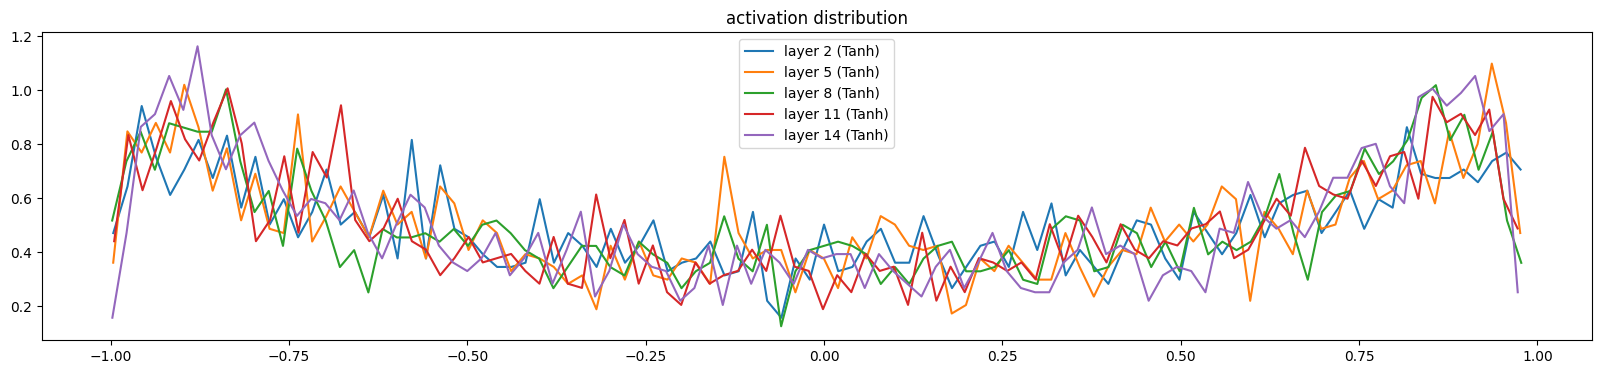

In [215]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    #print(layer.out.shape)
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')
print(f"\n{hx.shape = } <---")
print(f"{hy.shape = }")

layer 2 (      Tanh): mean -0.000000, std 2.983036e-03
layer 5 (      Tanh): mean +0.000000, std 2.612858e-03
layer 8 (      Tanh): mean +0.000000, std 2.371558e-03
layer 11 (      Tanh): mean +0.000000, std 2.185298e-03
layer 14 (      Tanh): mean +0.000000, std 2.191349e-03


Text(0.5, 1.0, 'gradient distribution')

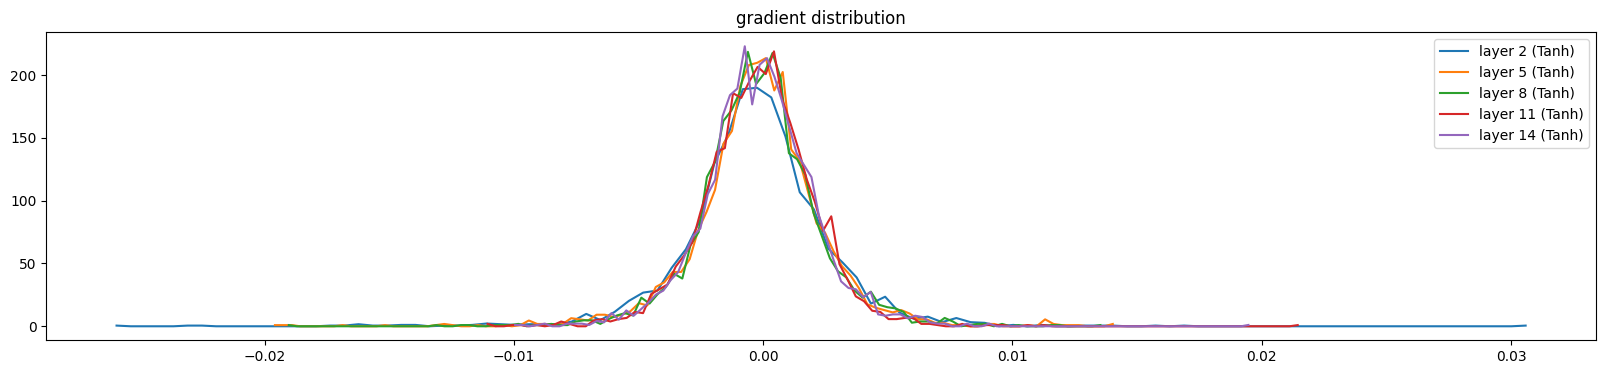

In [217]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    #print(f"{layer.out.grad.shape = }")
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

grad   (27, 10) | weight   (27, 10) | mean -0.000000 | std 1.108750e-02 | grad:data ratio 1.107219e-02
grad  (30, 100) | weight  (30, 100) | mean -0.000528 | std 1.171110e-02 | grad:data ratio 6.093733e-02
grad (100, 100) | weight (100, 100) | mean -0.000060 | std 8.530152e-03 | grad:data ratio 8.100330e-02
grad (100, 100) | weight (100, 100) | mean -0.000051 | std 6.795506e-03 | grad:data ratio 6.485417e-02
grad (100, 100) | weight (100, 100) | mean -0.000015 | std 6.323043e-03 | grad:data ratio 6.089053e-02
grad (100, 100) | weight (100, 100) | mean -0.000015 | std 6.075552e-03 | grad:data ratio 5.872782e-02
grad  (100, 27) | weight  (100, 27) | mean +0.000024 | std 1.259672e-02 | grad:data ratio 1.138889e-01


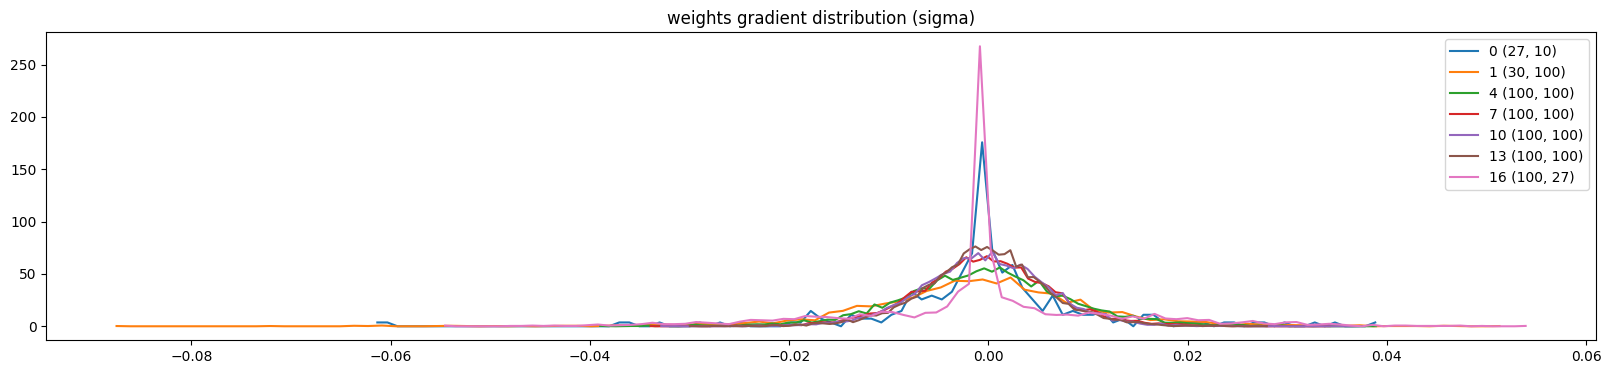

In [218]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        #print(f"{t.shape = }")
        print('grad %10s | weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(t.shape), tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution (sigma)');

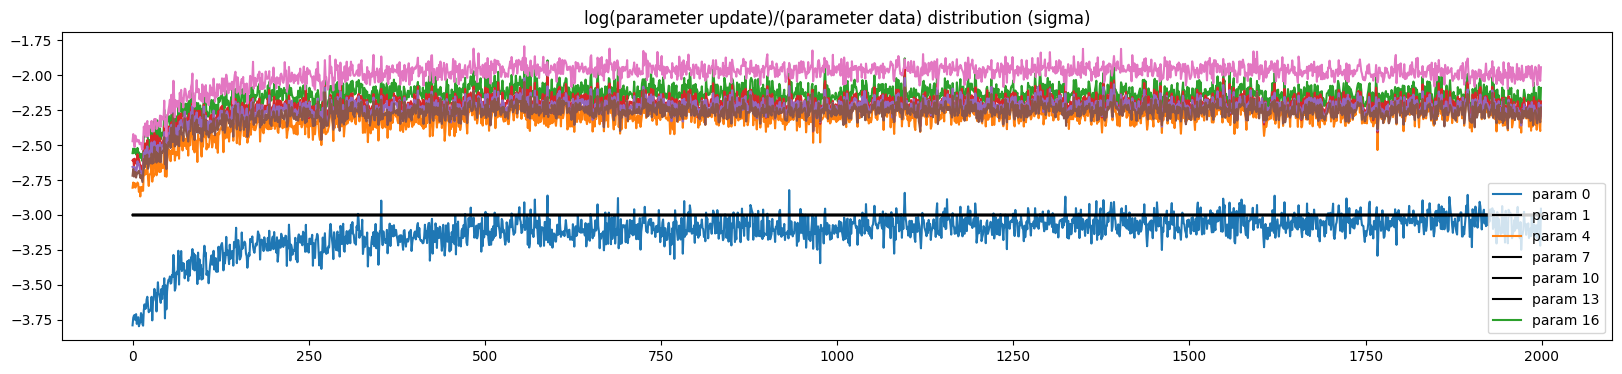

In [219]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
    plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title('log(parameter update)/(parameter data) distribution (sigma)');